In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pyhdx
from pyhdx.plot import plot_residue_map
import numpy as np
import itertools

In [2]:
pf = pyhdx.PeptideCSVFile("quiescent state data2.csv")

In [3]:
p_dict = pf.return_by_name('Full Deuteration control', .167)

In [4]:
p_dict.keys()

dict_keys(['Full Deuteration control_0.0', 'Full Deuteration control_0.167', 'SecA 1-834 ADP_0.0', 'SecA 1-834 ADP_0.167', 'SecA 1-834 ADP_0.5', 'SecA 1-834 ADP_1.0', 'SecA 1-834 ADP_2.0', 'SecA 1-834 ADP_5.0', 'SecA 1-834 ADP_10.0', 'SecA 1-834 ADP_30.0', 'SecA mono ADP_0.0', 'SecA mono ADP_0.167', 'SecA mono ADP_0.5', 'SecA mono ADP_1.0', 'SecA mono ADP_2.0', 'SecA mono ADP_5.0', 'SecA mono ADP_10.0', 'SecA mono ADP_30.0', 'SecA wt ADP_0.0', 'SecA wt ADP_0.167', 'SecA wt ADP_0.5', 'SecA wt ADP_1.0', 'SecA wt ADP_2.0', 'SecA wt ADP_5.0', 'SecA wt ADP_10.0', 'SecA wt ADP_30.0', 'SecA-monomer_0.0', 'SecA-monomer_0.167', 'SecA-monomer_0.5', 'SecA-monomer_1.0', 'SecA-monomer_2.0', 'SecA-monomer_5.0', 'SecA-monomer_10.0', 'SecA-monomer_30.0', 'SecA1-834 apo_0.0', 'SecA1-834 apo_0.167', 'SecA1-834 apo_0.5', 'SecA1-834 apo_1.0', 'SecA1-834 apo_2.0', 'SecA1-834 apo_5.0', 'SecA1-834 apo_10.0', 'SecA1-834 apo_30.0', 'SecA1-901 wt apo_0.0', 'SecA1-901 wt apo_0.167', 'SecA1-901 wt apo_0.5', 'SecA

In [5]:
s = p_dict['SecA mono ADP_0.5']

In [12]:
s.prot_len

872

In [13]:
s.start

30

<IPython.core.display.Javascript object>


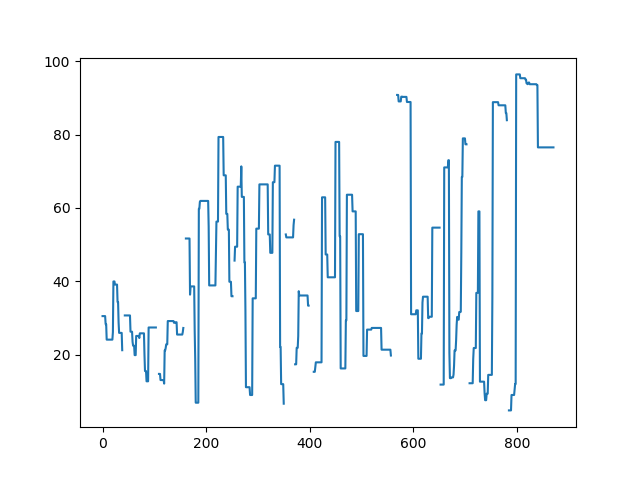

In [15]:
plt.figure()
plt.plot(s.scores_average)

<IPython.core.display.Javascript object>


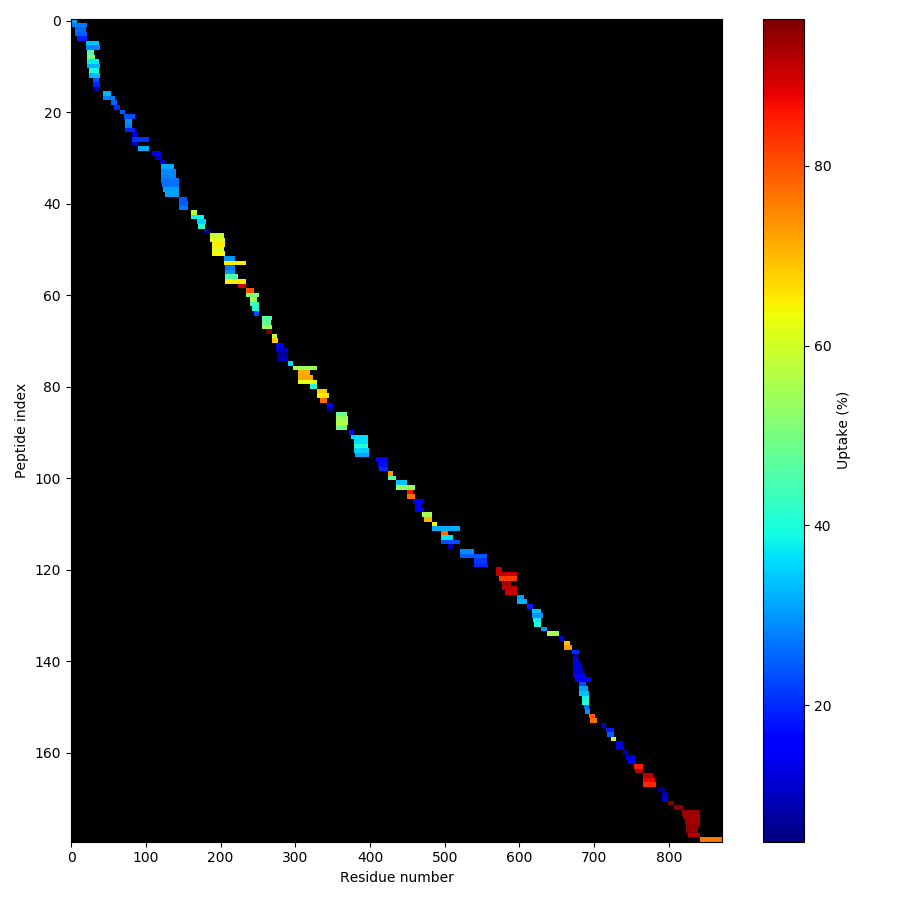

In [16]:
plt.figure(figsize=(9, 9))
plot_residue_map(s, aspect='auto')
plt.tight_layout()

In [17]:
times = [0.0, 0.167, 0.5, 1.0, 2.0, 5.0, 10.0, 30.0]
n = 'SecA wt ADP'

<IPython.core.display.Javascript object>


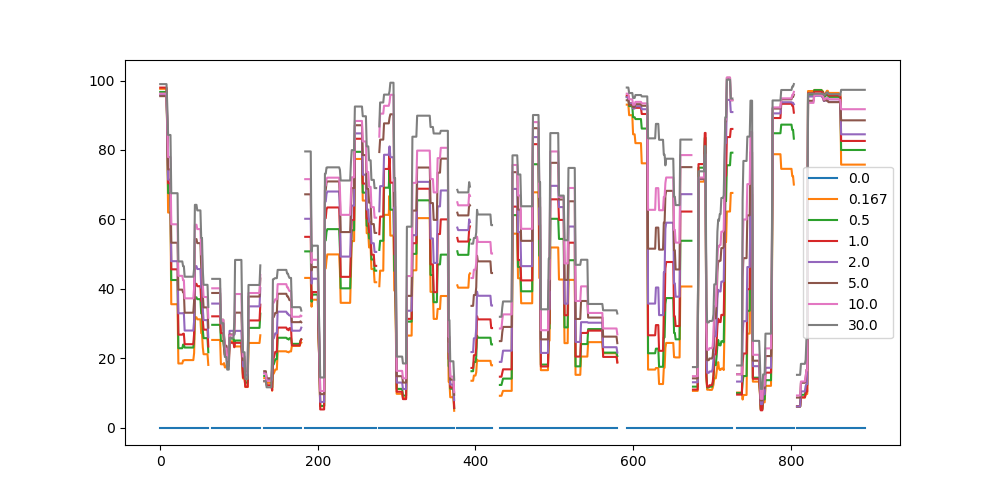

In [19]:
fig, ax1 = plt.subplots(1, figsize=(10,5), sharex=True)

for t in times:
    ax1.plot(p_dict[n+'_' + str(t)].scores_average, label=t)
    ax1.legend()

# Fitting

In [25]:
from symfit import Fit, Variable, Parameter, exp, Model
from symfit.core.minimizers import DifferentialEvolution, MINPACK, LBFGSB, BFGS
from scipy.optimize import fsolve

In [29]:
import scipy
scipy.__version__

'1.3.0'

In [37]:
import symfit
symfit.__version__

'0.5.0'

In [21]:
r = Parameter('r', value=0.5)
tau1 = Parameter('tau1')
tau2 = Parameter('tau2')
t = Variable('t')
y = Variable('y')
model =  Model({y: 100 *(1 - (r*exp(-t/tau1) + (1-r)*exp(-t/tau2)))})
model

In [22]:
def func_short(tau, tt, A):
    return 100*(1-np.exp(-tt/tau)) - A

def func_long(tau, tt, A, tau1):
    return 100*(1- (np.exp(-tt/tau1) + np.exp(-tt/tau) )) - A

def initial_guess(t, d, r=0.5):
    tau1 = fsolve(func_short, 2, args=(t[2], d[2]))[0]
    tau2 = fsolve(func_long, 20, args=(t[-1], d[-1], tau1))[0]
    
    return tau1, tau2

In [23]:
scores_2d = np.stack([p_dict[n + '_' + str(t)].scores_average for t in times])
scores_2d.shape

C:\Users\Smit\PycharmProjects\pyhdx\pyhdx\pyhdx.py:202: RuntimeWarning: invalid value encountered in true_divide
  return self.big_X / np.sum(self.big_X, axis=0)[np.newaxis, :]


(8, 895)

In [27]:
s = p_dict[n + '_0.5']

In [28]:
i = 0 
output = []
for (j, state) in zip(s.cs, s.states):
    
    print(j)
    arr = scores_2d[:, i:j]
    i = j

    if np.any(np.isnan(arr)): #states!
        output.append(np.nan)
        continue
    assert np.all(np.std(arr, axis=1) < 1e-10)

    d = arr[:, 0]
    chisq = np.inf
    #scan r for lowest chisquared
    for r_ in np.arange(0.1, 1, 0.1):
        t1, t2 = initial_guess(times, d, r=r_)
        f = model(np.array(times), r=r_, tau1=t1, tau2=t2)
        chisq_p = np.sum((d - f)**2)
        if chisq_p < chisq:
            t1f, t2f = t1, t2
            rf = r_
            chisq = chisq_p
            
    t1, t2 = initial_guess(times, d)
    
    tau1.value=t1
    tau2.value=min(t2, 100)
    r.value=r_
    
    fit = Fit(model, times, d, minimizer=MINPACK)
    res= fit.execute()
    
    rp = res.params['r']* res.params['tau1'] + (1-res.params['r'])*res.params['tau2']
    
    if np.isnan(rp):
        print('diffeeff')
        fit = Fit(model, times, d, minimizer=DifferentialEvolution)
        res= fit.execute()
    
        rp = res.params['r']* res.params['tau1'] + (1-res.params['r'])*res.params['tau2']
        print('result' , rp)
        if np.isnan(rp):

            print(j, state)
            print(d)
    output.append(rp)


9
10
14


C:\Miniconda3\envs\py_main\lib\site-packages\symfit\core\objectives.py:242: RuntimeWarning: overflow encountered in square
  result.append(((self.dependent_data[y] - ans) / self.sigma_data[self.model.sigmas[y]]) ** 2)
<string>:2: RuntimeWarning: overflow encountered in exp


23
29
31
43
44
47
52
54
55
61
62
66
77
81
82
85
88
94
95
104
105
108
112
127
128
132
135
142
143
145
146
149
161
163
164
167
178
179
180
184
192
193
201
202
203
209
211
212
228
229
242
243
247
257
262


<string>:2: RuntimeWarning: overflow encountered in multiply


265
268
272
275
278
279
284
291
292
297
299
300
308
313
320
326
343
347
352
356
366
368
373
374
377
378
392
393
394
395
398
401
402
403
420
422
431
434
435
447
454
458
473
481
483
493
495
506
513
518
527
534
543
562
580
581
592
595
600
603
611
619
629
633
639
641
642
652
654
660
675
676
683
691
693
694
697
701
702
703
706
707
708
709
710
712
715
716
717
719
724
727


C:\Miniconda3\envs\py_main\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


732
739
740
745
749
752
761
762
765
768
776
777
788
802
804
805
808
813
819
820
822
830
840
842
844
845
846
848
862
864
895


In [33]:
s.states


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1], dtype=int64)

In [35]:
x = np.repeat(output, s.counts)

<IPython.core.display.Javascript object>


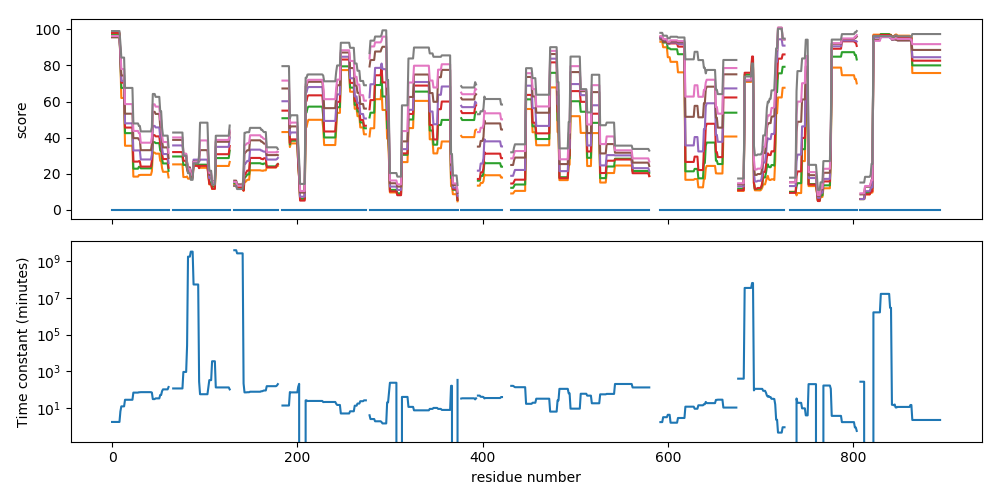

In [36]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,5), sharex=True)

for t in times:
    ax1.plot(p_dict[n+'_' + str(t)].scores_average, label=t)
    #ax1.legend()
ax2.plot(x)
ax2.set_yscale('log')
ax2.set_xlabel('residue number')
ax2.set_ylabel('Time constant (minutes)')
ax1.set_ylabel('score')
plt.tight_layout()
plt.savefig('Srinath_kinetics_WT_ADP')